In [1]:
import warnings
warnings.filterwarnings('ignore')

# Lab 4 - Data (ETL)

In [2]:
%matplotlib inline

## Lab

**Reid's** is a small breakfast stand that sells drinks (coffee, tea, sodas) and food (egg & sausage, oatmeal) in a commercial downtown area, Monday through Friday, from 8a until 11am.
Although their menu is small, they do try to cater to a wide variety of diets and thus provide both vegan and keto options for most of their meals.
They started using Ordr as their Point of Sale (POS) system about two months ago and are on the Basic Plan.

Under the Basic Plan, they are able to use the Ordr API to access orders.
This order information comes in the form of a denormalized JSON document.
In order to make any sense of things, we need to normalize it in the Datawarehouse.

## Part 1

We will create the following files:

1. **reids.sql** - this file will create the database structure using DDL.
2. **reids.db** - this is the actual database, our data warehouse.

```
> sqlite3 reids.db < reids.sql
```

will create the database and all the tables.
The database will be empty at this point.


3. **reids.py** - this program will parse the JSON file and fill the database.

```
> python reids.py
```

The documentations for the Ordr API is sparse, here is an example of one order:

```
{'items': [
    {'name': 'coffee', 'price': 2.75},
    {'name': 'flavor shot', 'price': 1.0}
    ],
'charges': {
    'date': '01/04/21 10:22',
    'subtotal': 3.75,
    'taxes': 0.26,
    'total': 4.01},
'payment': {
    'card_type': 'visa',
    'last_4_card_number': '0465',
    'zip': '21217',
    'cardholder': 'Christina Sampson',
    'method': 'credit_card'}}
```

**The date format is Month/Day/Year**


In [3]:
from tabulate import tabulate
import sqlite3
from datetime import datetime, timedelta
import matplotlib.pyplot as plt


In [4]:
con = sqlite3.connect('reids.db')
cursor = con.cursor()

### Question 1.

What were Reid's order count and gross revenue by day for the two month period?


First we will query the database. The query will select the Date and Total from the Charges table and group them all by date, summing the Totals as it groups. The query will also count the number of orders that are grouped for each date. Once we get the data, we print it and chart it.

+------------+--------------------+-------------+
|    Date    |   Gross Revenue    | # of Orders |
+------------+--------------------+-------------+
| 2021-04-01 |       188.87       |     34      |
| 2021-04-02 |       265.11       |     51      |
| 2021-04-05 |       339.77       |     57      |
| 2021-04-06 |       276.09       |     48      |
| 2021-04-07 |       188.63       |     32      |
| 2021-04-08 |       345.92       |     58      |
| 2021-04-09 |       341.58       |     62      |
| 2021-04-12 |       294.54       |     55      |
| 2021-04-13 |       167.5        |     32      |
| 2021-04-14 |       288.41       |     54      |
| 2021-04-15 |       262.69       |     45      |
| 2021-04-16 |       402.63       |     75      |
| 2021-04-19 |       276.1        |     49      |
| 2021-04-20 |       265.65       |     43      |
| 2021-04-21 |       207.62       |     39      |
| 2021-04-22 |       316.76       |     55      |
| 2021-04-23 |       408.49       |     75      |


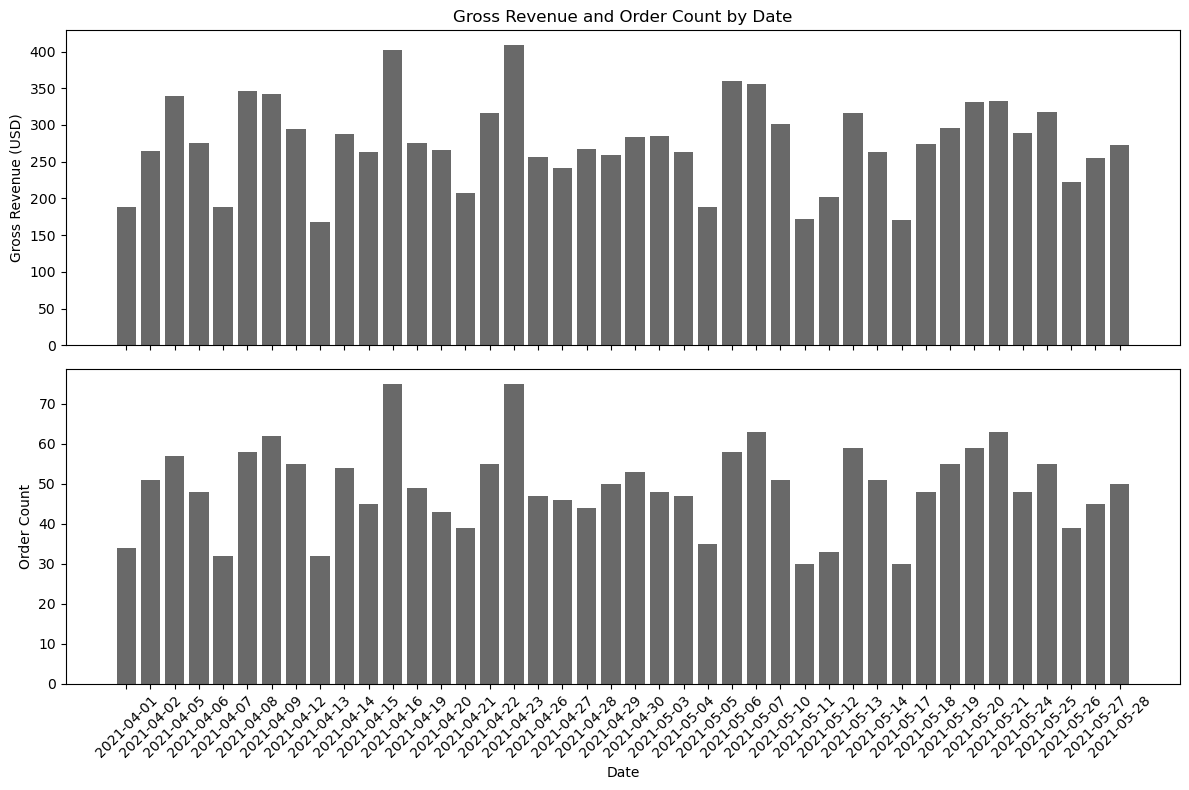

In [5]:
print(cursor.execute(
    """
        SELECT Charges.date, SUM(Charges.total), COUNT(Orders.order_id) AS order_count
        FROM Orders
        INNER JOIN Charges
        ON Orders.order_id = Charges.order_id
        GROUP BY Charges.date
        ORDER BY Charges.date

    """))
records = cursor.fetchall()

# print the data
headers = ["Date", "Gross Revenue", "# of Orders"]
table = tabulate(records, headers = headers, tablefmt = "pretty", floatfmt=".2f")
print(table)
      
    
# chart the data
dates = [record[0] for record in records]
total_revenue = [record[1] for record in records]
order_count = [record[2] for record in records]

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8), sharex=True)

# chart total revenue
ax1.bar(dates, total_revenue, color="dimgray")
ax1.set_ylabel('Gross Revenue (USD)')
ax1.set_title('Gross Revenue and Order Count by Date')

# chart order count
ax2.bar(dates, order_count, color="dimgray")
ax2.set_ylabel('Order Count')
ax2.set_xlabel('Date')

plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

After plotting the results, it is somewhat difficult to extract meaning or identify trends in the data. It's likely that the somewhat uniform fluctuations in the data are due to the weekly spending cycles of the customers.

### Question 2.

What is Reid's average order count and gross revenue by day of the week?


To answer this question, we can use the same SQL query as above. This time, we will use Python to process the data after it has been received from the database. 


After obtaining the data, we iterate through each record (which corresponds to a single day) and extract the day of the week that date corresponds to, using the datetime module. We store this data in the week_dict dictionary. Then we use the week_dict dictionary to create an array of tuples containing the averages we want, and use the array to print and chart our results.

We can predict that there will be no revenue on the weekends, since the shop does not appear to be open on weekends. We can also predict a slight uptick in sales at the beginnings and ends of weeks (Mondays and Fridays).


+-----------+--------------------+---------------------+
|    Day    |  Average Revenue   | Average # of Orders |
+-----------+--------------------+---------------------+
|  Monday   |     276.63125      |       48.125        |
|  Tuesday  |       247.23       |       43.625        |
| Wednesday |      232.7575      |       41.375        |
| Thursday  | 292.96666666666664 |  51.44444444444444  |
|  Friday   | 325.24444444444447 | 60.333333333333336  |
| Saturday  |         0          |          0          |
|  Sunday   |         0          |          0          |
+-----------+--------------------+---------------------+


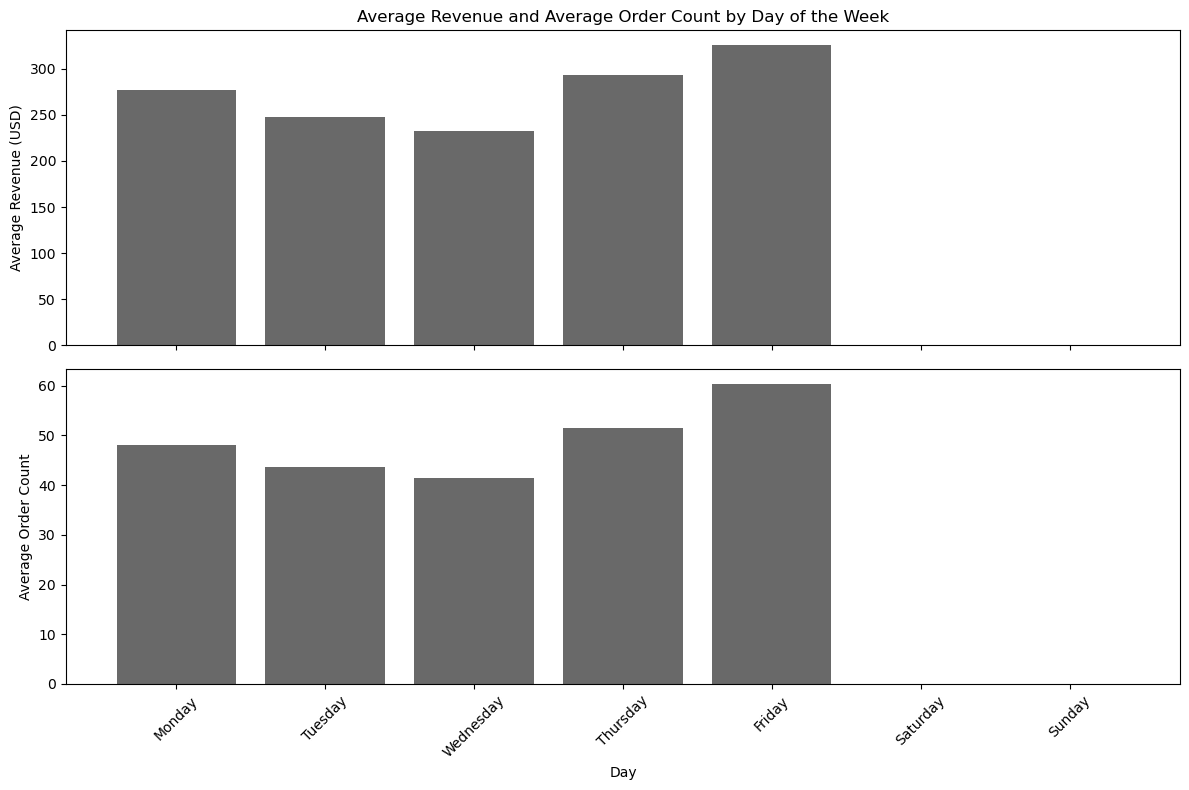

In [6]:
cursor.execute(
    """
        SELECT Charges.date, SUM(Charges.total), COUNT(Orders.order_id) AS order_count
        FROM Orders
        INNER JOIN Charges
        ON Orders.order_id = Charges.order_id
        GROUP BY Charges.date
        ORDER BY Charges.date

    """)
records = cursor.fetchall()


week_dict = {'Monday': {'total_revenue': 0, 'total_orders': 0, 'num_days': 0}, 'Tuesday': {'total_revenue': 0, 'total_orders': 0, 'num_days': 0}, 'Wednesday': {'total_revenue': 0, 'total_orders': 0, 'num_days': 0}, 'Thursday': {'total_revenue': 0, 'total_orders': 0, 'num_days': 0}, 'Friday': {'total_revenue': 0, 'total_orders': 0, 'num_days': 0}, 'Saturday': {'total_revenue': 0, 'total_orders': 0, 'num_days': 0}, 'Sunday': {'total_revenue': 0, 'total_orders': 0, 'num_days': 0}}

for record in records:
    date_object = datetime.strptime(record[0], '%Y-%m-%d')
    day_of_week = date_object.weekday()
    day_name = date_object.strftime('%A')
    week_dict[day_name]['total_revenue'] += record[1]
    week_dict[day_name]['total_orders'] += record[2]
    week_dict[day_name]['num_days'] += 1

daily_data = []

for day, data in week_dict.items():
    if (data['num_days'] > 0):
        daily_data.append((day, data['total_revenue']/data['num_days'], data['total_orders']/data['num_days']))
    else:
        daily_data.append((day, data['total_revenue'], data['total_orders']))

# print the data
headers = ["Day", "Average Revenue", "Average # of Orders"]
table = tabulate(daily_data, headers = headers, tablefmt = "pretty", floatfmt=".2f")
print(table)

# chart the data
days = [daily_datum[0] for daily_datum in daily_data]
avg_revenue = [daily_datum[1] for daily_datum in daily_data]
avg_orders = [daily_datum[2] for daily_datum in daily_data]

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8), sharex=True)

# chart average revenue
ax1.bar(days, avg_revenue, color="dimgray")
ax1.set_ylabel('Average Revenue (USD)')
ax1.set_title('Average Revenue and Average Order Count by Day of the Week')

# chart average order count
ax2.bar(days, avg_orders, color="dimgray")
ax2.set_ylabel('Average Order Count')
ax2.set_xlabel('Day')

plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

After plotting our data, our predictions were correct. There are no orders and no revenue on the weekends (Saturday and Sunday) and the most profitable days are Monday and Friday.

### Question 3.

How many cups of coffee does Reid's sell per day, on average?


To answer this question, we'll need a new SQL query on our database. This time we join the Items table and the Charges table to get the Date and the counts of items with different item_ids. We then select only the items with Item.name = 'coffee' and group by date. 


It is difficult to come up with a prediction for this query. I would imagine that Reid's sells somewhere between 5 and 50 cups of coffee per day. 


In [7]:
cursor.execute(
    """
        SELECT Charges.date, COUNT(Items.item_id) AS coffee_count
        FROM Charges
        INNER JOIN Items ON Charges.order_id = Items.order_id
        WHERE Items.name = 'coffee'
        GROUP BY Charges.date
        ORDER BY Charges.date
    """)
records = cursor.fetchall()

# print the data
headers = ["Date", "# of Coffees"]
table = tabulate(records, headers = headers, tablefmt = "pretty", floatfmt=".2f")
print(table)

coffees = 0
days = 0

for record in records:
    coffees += record[1]
    days += 1
avg_coffees = coffees/days
print("Average Number of Coffees per Day: " + f"{avg_coffees:.2f}")


+------------+--------------+
|    Date    | # of Coffees |
+------------+--------------+
| 2021-04-01 |      30      |
| 2021-04-02 |      31      |
| 2021-04-05 |      36      |
| 2021-04-06 |      34      |
| 2021-04-07 |      25      |
| 2021-04-08 |      43      |
| 2021-04-09 |      50      |
| 2021-04-12 |      37      |
| 2021-04-13 |      21      |
| 2021-04-14 |      39      |
| 2021-04-15 |      35      |
| 2021-04-16 |      56      |
| 2021-04-19 |      35      |
| 2021-04-20 |      35      |
| 2021-04-21 |      26      |
| 2021-04-22 |      46      |
| 2021-04-23 |      57      |
| 2021-04-26 |      33      |
| 2021-04-27 |      32      |
| 2021-04-28 |      32      |
| 2021-04-29 |      36      |
| 2021-04-30 |      37      |
| 2021-05-03 |      36      |
| 2021-05-04 |      36      |
| 2021-05-05 |      18      |
| 2021-05-06 |      49      |
| 2021-05-07 |      44      |
| 2021-05-10 |      37      |
| 2021-05-11 |      25      |
| 2021-05-12 |      27      |
| 2021-05-

It turns out that during the 2 month period, Reid's sold on average 36.1 cups of coffee per day. This was within our guess. There's no need to chart this result, as it's just a single value.

### Question 4.

What proportion of orders contain "up charges" like flavor shots, vegan or keto substitutions?


To answer this question, we first query the database. In this case, our query is simple. We select the order_id and name from the Items table. Then we run the data through an algorithm to count the number of orders that contain either a 'vegan' item, a 'keto' item or a 'flavor shot'. The algorithm also counts the total number of orders. At then end, the number of orders with upcharges is divided by the total number of orders. It is difficult to predict what percent of orders will have upcharges.

In [8]:
cursor.execute(
    """
        SELECT Items.order_id, Items.name
        FROM Items

    """)
records = cursor.fetchall()
# for record in records:
#     print(record)
    
    
num_upcharges = 0
num_orders = 0
upcharge = False
order = records[0][0]
index = 0

for record in records: 
    if (record[0] != order or index == len(records)-1):
        if (upcharge == True):
            num_upcharges += 1
            upcharge = False
        order = record[0]
        num_orders += 1
    if (record[1] == 'vegan' or record[1] == 'keto' or record[1] == 'flavor shot'):
        upcharge = True
    index += 1

print("num_upcharges: " + str(num_upcharges))
print("num_orders: " + str(num_orders))
print("Percent of Orders with Upcharges: " + f"{num_upcharges/num_orders:.2f}")
            

num_upcharges: 430
num_orders: 2070
Percent of Orders with Upcharges: 0.21


Our algorithm has found that 21% of orders have upcharges. This is a significant percent of orders.

### Question 5.

Reid's considers someone to be a "regular" if they come at least 3 out of 5 days per week. How many regulars do you estimate there are and what are their names? How many days per week do they each come on average? What are the limits of this calculation based on the available data?


One of the limits of this calculation is that the data has no name records for customers who paid with cash. It is possible that we are missing the names of some loyal customers who pay with cash sometimes or even exclusively pay with cash.


In order to find the number of regulars, we make three SQL queries. The first returns a list of Names and Dates of all non-cash charges ordered by date. The second two simply return the min and max dates, which are used to calculate the number of days of the sample period. We then run our results through an algorithm to count the number of visits per customer in the sample period, then compare those counts to the minimum number of visits required to be considered a regular customer. All customers who meet this requirement are added to a list along with their number of visits, and the list is tabulated.


In [9]:
cursor.execute(
    """
        SELECT Payments.cardholder, Charges.date
        FROM Payments
        INNER JOIN Charges
        ON Payments.order_id = Charges.order_id
        WHERE Payments.cardholder != 'None'
        ORDER BY Charges.date
    """
)

name_records = cursor.fetchall()

cursor.execute(
    """
        SELECT MIN(Charges.date)
        FROM Charges
    """
)
min_date = cursor.fetchall()

cursor.execute(
    """
        SELECT MAX(Charges.date)
        FROM Charges
    """
)
max_date = cursor.fetchall()


# Calculate the number of days in the sample
min_datetime = datetime.strptime(min_date[0][0], '%Y-%m-%d')
max_datetime = datetime.strptime(max_date[0][0], '%Y-%m-%d')

delta = max_datetime - min_datetime

num_days = delta.days


# Calculate the number of days each customer ordered from Reid's
customer_dict = {}

for record in name_records:
    if (record[0] in customer_dict):
        customer_dict[record[0]] += 1
    else:
        customer_dict[record[0]] = 1
        

# Create a list of customers who meet the regular customer visits threshold
regular_customers = []
visit_threshold = (3/7)*num_days
print("visit_threshold: " + f"{visit_threshold:.0f}")

for name, visits in customer_dict.items():
    if (visits >= visit_threshold):
        regular_customers.append((name, visits))

print("Number of Regular Customers: " + str(len(regular_customers)))
sorted_customers = sorted(regular_customers, key=lambda x: x[1], reverse=True)

# Print the data
headers = ["Name", "Visits From " + str(min_date[0][0]) + " to " + str(max_date[0][0])]
table = tabulate(sorted_customers, headers = headers, tablefmt = "pretty", floatfmt=".2f")
print(table)

    
con.close()

visit_threshold: 24
Number of Regular Customers: 30
+-------------------+--------------------------------------+
|       Name        | Visits From 2021-04-01 to 2021-05-28 |
+-------------------+--------------------------------------+
|   Rebecca Garza   |                  35                  |
|   Lisa Aguilar    |                  34                  |
|    Gina Green     |                  34                  |
|  Anthony Martin   |                  34                  |
|    Eric Bruce     |                  33                  |
|   Gregory Jones   |                  33                  |
| Cassandra Francis |                  33                  |
|   Wesley Garcia   |                  33                  |
|    Mary Jones     |                  33                  |
|   Emily Dennis    |                  32                  |
|  William Dunlap   |                  31                  |
|   Calvin Jones    |                  31                  |
|  Margaret Brown   |            

Above we can see the list of all customer who visited Reid's more than 24 times in the sample period. We conclude that there were 30 "regular" customers in the sample period.